<a href="https://colab.research.google.com/github/OritPa/ML_TripAdvisor_Pipeline/blob/main/Feature_selection_imbalane_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# SETUP
import warnings, joblib, pickle, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    log_loss, accuracy_score, precision_recall_fscore_support,
    roc_auc_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import ast
%matplotlib inline

In [2]:
# 1) Load your engineered dataframe (must contain 'target')
with open('df_after_feature_engineering.pkl', 'rb') as file:
    df = pickle.load(file)
assert "target" in df.columns, "df must contain a 'target' column."

y = df["target"].astype(int)
X = df.drop(columns=["target"])

# 2) Split once
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 3) Type inference
num_cols = X_train_raw.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X_train_raw.select_dtypes(include=["object", "category", "string"]).columns.tolist()
print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")

# 4) Preprocessor (fit once)
num_pipe = Pipeline([("impute", SimpleImputer(strategy="median"))])
# NOTE: OneHotEncoder(sparse_output=True) requires scikit-learn >=1.2
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.int8)),
])

pre = ColumnTransformer(
    [("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
    remainder="drop"
)
pre.fit(X_train_raw)

# 5) FS + imbalance steps (unfitted objects saved to reuse)
var_sel = VarianceThreshold(0.0)
fs_kbest = SelectKBest(score_func=mutual_info_classif, k=30)
smote = SMOTE(random_state=42)

# 6) Persist everything needed by later cells
joblib.dump(pre, "fitted_preprocessor.joblib")
joblib.dump((X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols), "data_split.joblib")
joblib.dump((var_sel, smote, fs_kbest), "pipeline_steps.joblib")

# 7) Create a results table if not exists
phase1_cols = ['Model','FS_Strategy','Test_ROC_AUC','Test_F1',
               'Test_Accuracy','Test_Precision','Test_Recall','Test_Log_Loss',
               'Pipeline_Path']
phase1_results = pd.DataFrame(columns=phase1_cols)
joblib.dump(phase1_results, "phase1_results_df.joblib")

print("Cell 1 done: artifacts saved.")


Numeric cols: 49 | Categorical cols: 6
Cell 1 done: artifacts saved.


###Random Forest

In [3]:
# 1) Load artifacts
pre = joblib.load("fitted_preprocessor.joblib")
X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols = joblib.load("data_split.joblib")
var_sel, smote, fs_kbest = joblib.load("pipeline_steps.joblib")
phase1_results = joblib.load("phase1_results_df.joblib")

# 2)
MODEL_NAME = "RandomForest"
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# 3) Build pipeline
pipe = ImbPipeline([
    ("pre", pre),
    ("var", var_sel),
    ("sel", fs_kbest),
    ("smote", smote),
    ("clf", classifier),
])

print(f"Fitting: {MODEL_NAME}")
pipe.fit(X_train_raw, y_train)

# 4) Predict + metrics
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    y_score = pipe.predict_proba(X_test_raw)[:, 1]
else:
    # roc_auc_score accepts decision_function scores
    y_score = pipe.decision_function(X_test_raw) if hasattr(pipe, "decision_function") else None

y_pred = pipe.predict(X_test_raw)

test_auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
test_acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average=None)
test_prec = prf[0][1]
test_recall = prf[1][1]
test_f1_pos = prf[2][1]
test_logloss = log_loss(y_test, y_score) if y_score is not None and y_score.ndim == 1 else np.nan

# 5) Save model + append results
model_path = f"pipe_{MODEL_NAME}_P1.joblib"
joblib.dump(pipe, model_path)

new_row = pd.DataFrame([{
    'Model': MODEL_NAME,
    'FS_Strategy': 'VT + SelectKBest(mi,k=30)',
    'Test_ROC_AUC': round(float(test_auc), 4) if not np.isnan(test_auc) else np.nan,
    'Test_F1': round(float(test_f1_pos), 4),
    'Test_Accuracy': round(float(test_acc), 4),
    'Test_Precision': round(float(test_prec), 4),
    'Test_Recall': round(float(test_recall), 4),
    'Test_Log_Loss': round(float(test_logloss), 4) if not np.isnan(test_logloss) else np.nan,
    'Pipeline_Path': model_path
}])

phase1_results = pd.concat([phase1_results, new_row], ignore_index=True)
joblib.dump(phase1_results, "phase1_results_df.joblib")

print("\n Saved metrics and pipeline.")
print(new_row)


Fitting: RandomForest

 Saved metrics and pipeline.
          Model                FS_Strategy  Test_ROC_AUC  Test_F1  \
0  RandomForest  VT + SelectKBest(mi,k=30)        0.9658   0.6742   

   Test_Accuracy  Test_Precision  Test_Recall  Test_Log_Loss  \
0         0.9464          0.7129       0.6396         0.1444   

                 Pipeline_Path  
0  pipe_RandomForest_P1.joblib  


###Logistic Regression

In [4]:
# 1) Load artifacts
pre = joblib.load("fitted_preprocessor.joblib")
X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols = joblib.load("data_split.joblib")
var_sel, smote, fs_kbest = joblib.load("pipeline_steps.joblib")
phase1_results = joblib.load("phase1_results_df.joblib")

# 2)
MODEL_NAME, classifier = "LogReg", LogisticRegression(max_iter=2000, random_state=42)

# 3) Build pipeline
pipe = ImbPipeline([
    ("pre", pre),
    ("var", var_sel),
    ("sel", fs_kbest),
    ("smote", smote),
    ("clf", classifier),
])

print(f"Fitting: {MODEL_NAME}")
pipe.fit(X_train_raw, y_train)

# 4) Predict + metrics
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    y_score = pipe.predict_proba(X_test_raw)[:, 1]
else:
    # Handle margin-based models (e.g., LinearSVM) for ROC-AUC
    # roc_auc_score accepts decision_function scores
    y_score = pipe.decision_function(X_test_raw) if hasattr(pipe, "decision_function") else None

y_pred = pipe.predict(X_test_raw)

test_auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
test_acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average=None)
test_prec = prf[0][1]
test_recall = prf[1][1]
test_f1_pos = prf[2][1]
test_logloss = log_loss(y_test, y_score) if y_score is not None and y_score.ndim == 1 else np.nan

# 5) Save model + append results
model_path = f"pipe_{MODEL_NAME}_P1.joblib"
joblib.dump(pipe, model_path)

new_row = pd.DataFrame([{
    'Model': MODEL_NAME,
    'FS_Strategy': 'VT + SelectKBest(mi,k=30)',
    'Test_ROC_AUC': round(float(test_auc), 4) if not np.isnan(test_auc) else np.nan,
    'Test_F1': round(float(test_f1_pos), 4),
    'Test_Accuracy': round(float(test_acc), 4),
    'Test_Precision': round(float(test_prec), 4),
    'Test_Recall': round(float(test_recall), 4),
    'Test_Log_Loss': round(float(test_logloss), 4) if not np.isnan(test_logloss) else np.nan,
    'Pipeline_Path': model_path
}])

phase1_results = pd.concat([phase1_results, new_row], ignore_index=True)
joblib.dump(phase1_results, "phase1_results_df.joblib")

print("\n Saved metrics and pipeline.")
print(new_row)


Fitting: LogReg

 Saved metrics and pipeline.
    Model                FS_Strategy  Test_ROC_AUC  Test_F1  Test_Accuracy  \
0  LogReg  VT + SelectKBest(mi,k=30)        0.9493    0.536         0.8599   

   Test_Precision  Test_Recall  Test_Log_Loss          Pipeline_Path  
0          0.3759       0.9333         0.2914  pipe_LogReg_P1.joblib  


###XGB Classifier

In [5]:
# 1) Load artifacts
pre = joblib.load("fitted_preprocessor.joblib")
X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols = joblib.load("data_split.joblib")
var_sel, smote, fs_kbest = joblib.load("pipeline_steps.joblib")
phase1_results = joblib.load("phase1_results_df.joblib")

# 2)
MODEL_NAME, classifier = "XGB", XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1, tree_method="hist")

# 3) Build pipeline
pipe = ImbPipeline([
    ("pre", pre),
    ("var", var_sel),
    ("sel", fs_kbest),
    ("smote", smote),
    ("clf", classifier),
])

print(f"Fitting: {MODEL_NAME}")
pipe.fit(X_train_raw, y_train)

# 4) Predict + metrics
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    y_score = pipe.predict_proba(X_test_raw)[:, 1]
else:
    # Handle margin-based models (e.g., LinearSVM) for ROC-AUC
    # roc_auc_score accepts decision_function scores
    y_score = pipe.decision_function(X_test_raw) if hasattr(pipe, "decision_function") else None

y_pred = pipe.predict(X_test_raw)

test_auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
test_acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average=None)
test_prec = prf[0][1]
test_recall = prf[1][1]
test_f1_pos = prf[2][1]
test_logloss = log_loss(y_test, y_score) if y_score is not None and y_score.ndim == 1 else np.nan

# 5) Save model + append results
model_path = f"pipe_{MODEL_NAME}_P1.joblib"
joblib.dump(pipe, model_path)

new_row = pd.DataFrame([{
    'Model': MODEL_NAME,
    'FS_Strategy': 'VT + SelectKBest(mi,k=30)',
    'Test_ROC_AUC': round(float(test_auc), 4) if not np.isnan(test_auc) else np.nan,
    'Test_F1': round(float(test_f1_pos), 4),
    'Test_Accuracy': round(float(test_acc), 4),
    'Test_Precision': round(float(test_prec), 4),
    'Test_Recall': round(float(test_recall), 4),
    'Test_Log_Loss': round(float(test_logloss), 4) if not np.isnan(test_logloss) else np.nan,
    'Pipeline_Path': model_path
}])

phase1_results = pd.concat([phase1_results, new_row], ignore_index=True)
joblib.dump(phase1_results, "phase1_results_df.joblib")

print("\n Saved metrics and pipeline.")
print(new_row)


Fitting: XGB

 Saved metrics and pipeline.
  Model                FS_Strategy  Test_ROC_AUC  Test_F1  Test_Accuracy  \
0   XGB  VT + SelectKBest(mi,k=30)        0.9716   0.6963         0.9482   

   Test_Precision  Test_Recall  Test_Log_Loss       Pipeline_Path  
0          0.7086       0.6845         0.1178  pipe_XGB_P1.joblib  


###Decision Tree

In [6]:
# 1) Load artifacts
pre = joblib.load("fitted_preprocessor.joblib")
X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols = joblib.load("data_split.joblib")
var_sel, smote, fs_kbest = joblib.load("pipeline_steps.joblib")
phase1_results = joblib.load("phase1_results_df.joblib")

# 2)
MODEL_NAME, classifier = "DecisionTree", DecisionTreeClassifier(random_state=42)


# 3) Build pipeline
pipe = ImbPipeline([
    ("pre", pre),
    ("var", var_sel),
    ("sel", fs_kbest),
    ("smote", smote),
    ("clf", classifier),
])

print(f"Fitting: {MODEL_NAME}")
pipe.fit(X_train_raw, y_train)

# 4) Predict + metrics
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    y_score = pipe.predict_proba(X_test_raw)[:, 1]
else:
    # Handle margin-based models (e.g., LinearSVM) for ROC-AUC
    # roc_auc_score accepts decision_function scores
    y_score = pipe.decision_function(X_test_raw) if hasattr(pipe, "decision_function") else None

y_pred = pipe.predict(X_test_raw)

test_auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
test_acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average=None)
test_prec = prf[0][1]
test_recall = prf[1][1]
test_f1_pos = prf[2][1]
test_logloss = log_loss(y_test, y_score) if y_score is not None and y_score.ndim == 1 else np.nan

# 5) Save model + append results
model_path = f"pipe_{MODEL_NAME}_P1.joblib"
joblib.dump(pipe, model_path)

new_row = pd.DataFrame([{
    'Model': MODEL_NAME,
    'FS_Strategy': 'VT + SelectKBest(mi,k=30)',
    'Test_ROC_AUC': round(float(test_auc), 4) if not np.isnan(test_auc) else np.nan,
    'Test_F1': round(float(test_f1_pos), 4),
    'Test_Accuracy': round(float(test_acc), 4),
    'Test_Precision': round(float(test_prec), 4),
    'Test_Recall': round(float(test_recall), 4),
    'Test_Log_Loss': round(float(test_logloss), 4) if not np.isnan(test_logloss) else np.nan,
    'Pipeline_Path': model_path
}])

phase1_results = pd.concat([phase1_results, new_row], ignore_index=True)
joblib.dump(phase1_results, "phase1_results_df.joblib")

print("\n Saved metrics and pipeline.")
print(new_row)


Fitting: DecisionTree

 Saved metrics and pipeline.
          Model                FS_Strategy  Test_ROC_AUC  Test_F1  \
0  DecisionTree  VT + SelectKBest(mi,k=30)        0.7852   0.5899   

   Test_Accuracy  Test_Precision  Test_Recall  Test_Log_Loss  \
0         0.9262          0.5693       0.6121         2.6499   

                 Pipeline_Path  
0  pipe_DecisionTree_P1.joblib  


###Gradient Boosting Classifier

In [7]:
# 1) Load artifacts
pre = joblib.load("fitted_preprocessor.joblib")
X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols = joblib.load("data_split.joblib")
var_sel, smote, fs_kbest = joblib.load("pipeline_steps.joblib")
phase1_results = joblib.load("phase1_results_df.joblib")

# 2)
MODEL_NAME, classifier = "GBM", GradientBoostingClassifier(random_state=42)


# 3) Build pipeline
pipe = ImbPipeline([
    ("pre", pre),
    ("var", var_sel),
    ("sel", fs_kbest),
    ("smote", smote),
    ("clf", classifier),
])

print(f"Fitting: {MODEL_NAME}")
pipe.fit(X_train_raw, y_train)

# 4) Predict + metrics
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    y_score = pipe.predict_proba(X_test_raw)[:, 1]
else:
    # Handle margin-based models (e.g., LinearSVM) for ROC-AUC
    # roc_auc_score accepts decision_function scores
    y_score = pipe.decision_function(X_test_raw) if hasattr(pipe, "decision_function") else None

y_pred = pipe.predict(X_test_raw)

test_auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
test_acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average=None)
test_prec = prf[0][1]
test_recall = prf[1][1]
test_f1_pos = prf[2][1]
test_logloss = log_loss(y_test, y_score) if y_score is not None and y_score.ndim == 1 else np.nan

# 5) Save model + append results
model_path = f"pipe_{MODEL_NAME}_P1.joblib"
joblib.dump(pipe, model_path)

new_row = pd.DataFrame([{
    'Model': MODEL_NAME,
    'FS_Strategy': 'VT + SelectKBest(mi,k=30)',
    'Test_ROC_AUC': round(float(test_auc), 4) if not np.isnan(test_auc) else np.nan,
    'Test_F1': round(float(test_f1_pos), 4),
    'Test_Accuracy': round(float(test_acc), 4),
    'Test_Precision': round(float(test_prec), 4),
    'Test_Recall': round(float(test_recall), 4),
    'Test_Log_Loss': round(float(test_logloss), 4) if not np.isnan(test_logloss) else np.nan,
    'Pipeline_Path': model_path
}])

phase1_results = pd.concat([phase1_results, new_row], ignore_index=True)
joblib.dump(phase1_results, "phase1_results_df.joblib")

print("\n Saved metrics and pipeline.")
print(new_row)


Fitting: GBM

 Saved metrics and pipeline.
  Model                FS_Strategy  Test_ROC_AUC  Test_F1  Test_Accuracy  \
0   GBM  VT + SelectKBest(mi,k=30)        0.9688   0.6848           0.94   

   Test_Precision  Test_Recall  Test_Log_Loss       Pipeline_Path  
0          0.6293       0.7512         0.1326  pipe_GBM_P1.joblib  


###Linear SVM

In [8]:
# 1) Load artifacts
pre = joblib.load("fitted_preprocessor.joblib")
X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols = joblib.load("data_split.joblib")
var_sel, smote, fs_kbest = joblib.load("pipeline_steps.joblib")
phase1_results = joblib.load("phase1_results_df.joblib")

# 2)
MODEL_NAME, classifier = "LinearSVM", LinearSVC(dual=False, random_state=42, max_iter=3000)
#Note: due to size and long processing time did not try regular SVM

# 3) Build pipeline
pipe = ImbPipeline([
    ("pre", pre),
    ("var", var_sel),
    ("sel", fs_kbest),
    ("smote", smote),
    ("clf", classifier),
])

print(f"Fitting: {MODEL_NAME}")
pipe.fit(X_train_raw, y_train)

# 4) Predict + metrics
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    y_score = pipe.predict_proba(X_test_raw)[:, 1]
else:
    # Handle margin-based models (e.g., LinearSVM) for ROC-AUC
    # roc_auc_score accepts decision_function scores
    y_score = pipe.decision_function(X_test_raw) if hasattr(pipe, "decision_function") else None

y_pred = pipe.predict(X_test_raw)

test_auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
test_acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average=None)
test_prec = prf[0][1]
test_recall = prf[1][1]
test_f1_pos = prf[2][1]
test_logloss = log_loss(y_test, y_score) if y_score is not None and y_score.ndim == 1 else np.nan

# 5) Save model + append results
model_path = f"pipe_{MODEL_NAME}_P1.joblib"
joblib.dump(pipe, model_path)

new_row = pd.DataFrame([{
    'Model': MODEL_NAME,
    'FS_Strategy': 'VT + SelectKBest(mi,k=30)',
    'Test_ROC_AUC': round(float(test_auc), 4) if not np.isnan(test_auc) else np.nan,
    'Test_F1': round(float(test_f1_pos), 4),
    'Test_Accuracy': round(float(test_acc), 4),
    'Test_Precision': round(float(test_prec), 4),
    'Test_Recall': round(float(test_recall), 4),
    'Test_Log_Loss': round(float(test_logloss), 4) if not np.isnan(test_logloss) else np.nan,
    'Pipeline_Path': model_path
}])

phase1_results = pd.concat([phase1_results, new_row], ignore_index=True)
joblib.dump(phase1_results, "phase1_results_df.joblib")

print("\n Saved metrics and pipeline.")
print(new_row)


Fitting: LinearSVM

 Saved metrics and pipeline.
       Model                FS_Strategy  Test_ROC_AUC  Test_F1  Test_Accuracy  \
0  LinearSVM  VT + SelectKBest(mi,k=30)        0.9557   0.5305         0.8558   

   Test_Precision  Test_Recall  Test_Log_Loss             Pipeline_Path  
0          0.3696       0.9397         0.5033  pipe_LinearSVM_P1.joblib  


###Ada Boost Classifier

In [9]:
# 1) Load artifacts
pre = joblib.load("fitted_preprocessor.joblib")
X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols = joblib.load("data_split.joblib")
var_sel, smote, fs_kbest = joblib.load("pipeline_steps.joblib")
phase1_results = joblib.load("phase1_results_df.joblib")

# 2)
MODEL_NAME = "Ada"
classifier = AdaBoostClassifier(random_state=42)

# 3) Build pipeline
pipe = ImbPipeline([
    ("pre", pre),
    ("var", var_sel),
    ("sel", fs_kbest),
    ("smote", smote),
    ("clf", classifier),
])

print(f"Fitting: {MODEL_NAME}")
pipe.fit(X_train_raw, y_train)

# 4) Predict + metrics
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    y_score = pipe.predict_proba(X_test_raw)[:, 1]
else:
    # Handle margin-based models (e.g., LinearSVM) for ROC-AUC
    # roc_auc_score accepts decision_function scores
    y_score = pipe.decision_function(X_test_raw) if hasattr(pipe, "decision_function") else None

y_pred = pipe.predict(X_test_raw)

test_auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
test_acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred, average=None)
test_prec = prf[0][1]
test_recall = prf[1][1]
test_f1_pos = prf[2][1]
test_logloss = log_loss(y_test, y_score) if y_score is not None and y_score.ndim == 1 else np.nan

# 5) Save model + append results
model_path = f"pipe_{MODEL_NAME}_P1.joblib"
joblib.dump(pipe, model_path)

new_row = pd.DataFrame([{
    'Model': MODEL_NAME,
    'FS_Strategy': 'VT + SelectKBest(mi,k=30)',
    'Test_ROC_AUC': round(float(test_auc), 4) if not np.isnan(test_auc) else np.nan,
    'Test_F1': round(float(test_f1_pos), 4),
    'Test_Accuracy': round(float(test_acc), 4),
    'Test_Precision': round(float(test_prec), 4),
    'Test_Recall': round(float(test_recall), 4),
    'Test_Log_Loss': round(float(test_logloss), 4) if not np.isnan(test_logloss) else np.nan,
    'Pipeline_Path': model_path
}])

phase1_results = pd.concat([phase1_results, new_row], ignore_index=True)
joblib.dump(phase1_results, "phase1_results_df.joblib")

print("\n Saved metrics and pipeline.")
print(new_row)


Fitting: Ada

 Saved metrics and pipeline.
  Model                FS_Strategy  Test_ROC_AUC  Test_F1  Test_Accuracy  \
0   Ada  VT + SelectKBest(mi,k=30)        0.9588   0.6468         0.9278   

   Test_Precision  Test_Recall  Test_Log_Loss       Pipeline_Path  
0          0.5619       0.7619          0.449  pipe_Ada_P1.joblib  



=== PHASE 1 Leaderboard ===


,Model,Test_ROC_AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_Log_Loss
0,XGB,0.9716,0.9482,0.7086,0.6845,0.6963,0.1178
1,GBM,0.9688,0.9400,0.6293,0.7512,0.6848,0.1326
2,RandomForest,0.9658,0.9464,0.7129,0.6396,0.6742,0.1444
3,Ada,0.9588,0.9278,0.5619,0.7619,0.6468,0.4490
4,LinearSVM,0.9557,0.8558,0.3696,0.9397,0.5305,0.5033
5,LogReg,0.9493,0.8599,0.3759,0.9333,0.5360,0.2914
6,DecisionTree,0.7852,0.9262,0.5693,0.6121,0.5899,2.6499



 Winner selected for tuning: XGB

=== Tuning XGBClassifier ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 500}
Best CV ROC AUC: 0.9724


,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Tuned_XGB,0.9478,0.7074,0.6786,0.6927,0.9721


<Figure size 500x400 with 0 Axes>

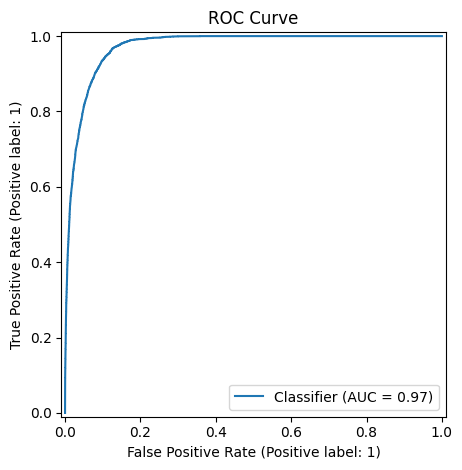

<Figure size 500x400 with 0 Axes>

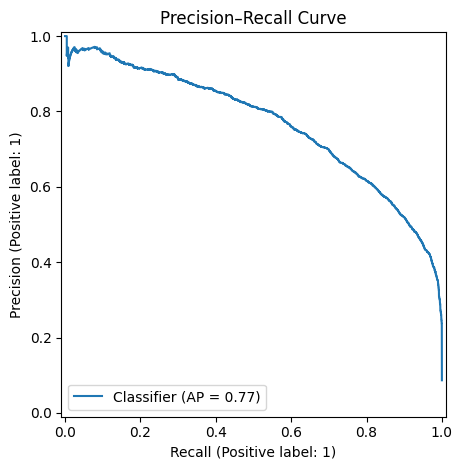

<Figure size 400x400 with 0 Axes>

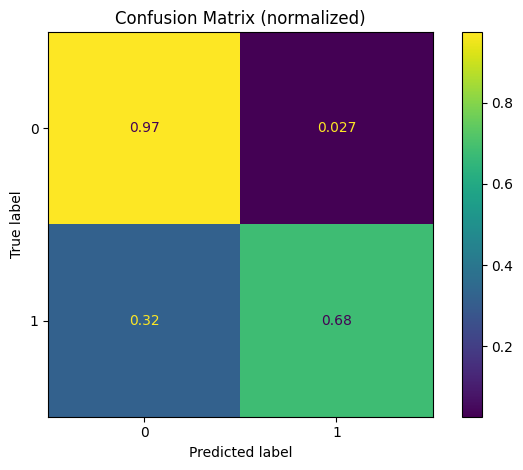


✅ Saved selected features to selected_features.csv (top 30 shown).


,Feature,MI_Score
0,num__relative_popularity_rank,0.147095
1,num__awards,0.108124
2,cat__default_language_All languages,0.077401
3,cat__default_language_English,0.068865
4,num__gluten_free,0.068571
5,num__claimed,0.058305
6,num__vegetarian_friendly,0.054113
7,num__is_weekend_open_any,0.049354
8,num__is_weekday_open_any,0.047793
9,num__open_hours_per_week,0.044815


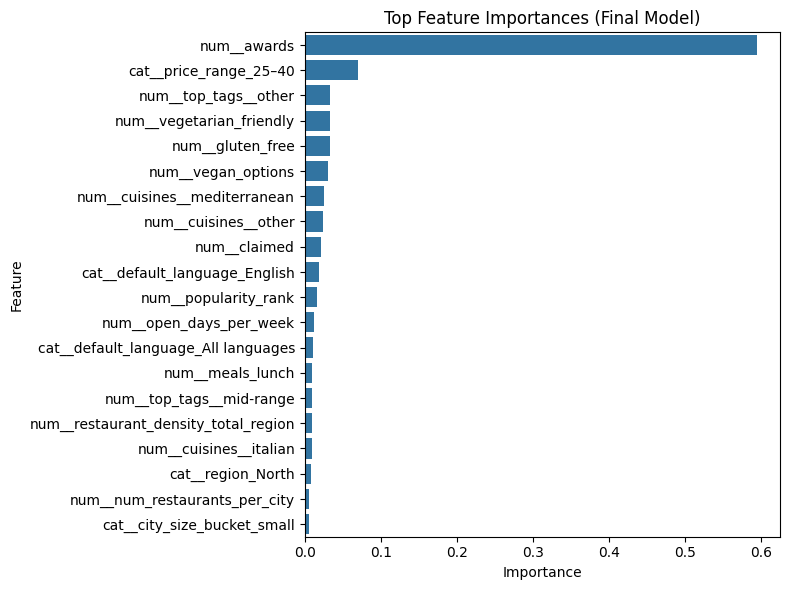

,Feature,Importance
1,num__awards,0.595380
26,cat__price_range_25–40,0.070468
13,num__top_tags__other,0.033477
3,num__vegetarian_friendly,0.032902
5,num__gluten_free,0.032751
4,num__vegan_options,0.031015
10,num__cuisines__mediterranean,0.025651
11,num__cuisines__other,0.023903
0,num__claimed,0.021693
28,cat__default_language_English,0.018183


Saved: best_Tuned_XGB_pipeline.joblib, chosen_params.json, selected_model_metrics.csv, selected_features.(csv/json)


In [10]:
# LEADERBOARD + TUNING + FEATURE LIST + PLOTS
import joblib, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# 1) Load artifacts
pre = joblib.load("fitted_preprocessor.joblib")
X_train_raw, X_test_raw, y_train, y_test, num_cols, cat_cols = joblib.load("data_split.joblib")
var_sel, smote, fs_kbest = joblib.load("pipeline_steps.joblib")
phase1_results = joblib.load("phase1_results_df.joblib")

# 2) Leaderboard
if phase1_results.empty:
    raise RuntimeError("No model results found. Run a few models in Cell 2 first.")

summary = phase1_results.sort_values("Test_ROC_AUC", ascending=False).reset_index(drop=True)
print("\n=== PHASE 1 Leaderboard ===")
display(summary[['Model','Test_ROC_AUC','Test_Accuracy','Test_Precision','Test_Recall','Test_F1','Test_Log_Loss']])

best_row = summary.dropna(subset=['Test_ROC_AUC']).iloc[0]
winner_name = best_row["Model"]
print(f"\n Winner selected for tuning: {winner_name}")

# 3) Load winning pipeline
winner_pipe = joblib.load(best_row["Pipeline_Path"])
winner_clf_name = winner_pipe.named_steps["clf"].__class__.__name__

# 4) Param grids per winner
param_grid = {}
if winner_clf_name == "XGBClassifier":
    param_grid = {"clf__n_estimators":[300,500], "clf__learning_rate":[0.05,0.1], "clf__max_depth":[4,6]}
elif winner_clf_name == "RandomForestClassifier":
    param_grid = {"clf__n_estimators":[400,600], "clf__max_depth":[8,12,None], "clf__min_samples_leaf":[1,5]}
elif winner_clf_name == "LogisticRegression":
    param_grid = {"clf__C":[0.5,1.0,2.0], "clf__penalty":["l2"], "clf__solver":["lbfgs","liblinear"]}
elif winner_clf_name == "SVC":
    param_grid = {"clf__C":[0.5,1,2], "clf__gamma":["scale",0.1]}
# else: leave empty -> no tuning

# 5) Tuning (if grid provided)
best_params = {}
best_pipe = winner_pipe
if param_grid:
    print(f"\n=== Tuning {winner_clf_name} ===")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(winner_pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=1, refit=True)
    gs.fit(X_train_raw, y_train)
    best_pipe = gs.best_estimator_
    best_params = gs.best_params_
    print("Best params:", best_params)
    print(f"Best CV ROC AUC: {gs.best_score_:.4f}")

# Persist chosen params for record
with open("chosen_params.json","w") as f:
    json.dump(best_params, f, indent=2)

# 6) Final evaluation on test
y_score = (best_pipe.predict_proba(X_test_raw)[:,1]
           if hasattr(best_pipe.named_steps["clf"], "predict_proba")
           else (best_pipe.decision_function(X_test_raw) if hasattr(best_pipe, "decision_function") else None))
y_pred = best_pipe.predict(X_test_raw)

metrics_tbl = pd.DataFrame([{
    "Model": f"Tuned_{winner_name}" if param_grid else winner_name,
    "Accuracy": round(accuracy_score(y_test, y_pred), 4),
    "Precision": round(precision_score(y_test, y_pred), 4),
    "Recall": round(recall_score(y_test, y_pred), 4),
    "F1": round(f1_score(y_test, y_pred), 4),
    "ROC AUC": round(roc_auc_score(y_test, y_score), 4) if y_score is not None else np.nan,
}])
display(metrics_tbl)

# 7) Plots: ROC, PR, Confusion Matrix
if y_score is not None:
    plt.figure(figsize=(5,4)); RocCurveDisplay.from_predictions(y_test, y_score)
    plt.title('ROC Curve'); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5,4)); PrecisionRecallDisplay.from_predictions(y_test, y_score)
    plt.title('Precision–Recall Curve'); plt.tight_layout(); plt.show()

plt.figure(figsize=(4,4)); ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.title('Confusion Matrix (normalized)'); plt.tight_layout(); plt.show()

# 8) Selected feature list (names + MI scores from SelectKBest)
#    We re-fit the FS steps on the TRAIN TRANSFORMED data to extract the masks + scores.
from sklearn.feature_selection import SelectKBest, mutual_info_classif
X_train_trans = pre.transform(X_train_raw)               # pre is already fitted
var_masked = var_sel.fit_transform(X_train_trans)        # fit to get its mask
var_mask = var_sel.get_support()
feat_names_after_ohe = pre.get_feature_names_out()
feat_after_var = np.array(feat_names_after_ohe)[var_mask]  # names after VT

fs_kbest.fit(var_masked, y_train)                        # fit to compute MI and select top-k
kbest_mask = fs_kbest.get_support()
selected_names = feat_after_var[kbest_mask]
selected_scores_all = pd.Series(fs_kbest.scores_, index=feat_after_var)
selected_scores = selected_scores_all.loc[selected_names].sort_values(ascending=False)

selected_df = pd.DataFrame({"Feature": selected_scores.index, "MI_Score": selected_scores.values})
selected_df.to_csv("selected_features.csv", index=False)
with open("selected_features.json","w") as f:
    json.dump(selected_df.to_dict(orient="records"), f, indent=2)

print(f"\n✅ Saved selected features to selected_features.csv (top {len(selected_df)} shown).")
display(selected_df.head(20))

# 9) Optional: feature importance (tree-based models)
importances = None
clf = best_pipe.named_steps["clf"]
if hasattr(clf, "feature_importances_"):
    # Map importances to the final selected feature space
    if len(clf.feature_importances_) == len(selected_names):
        importances = pd.DataFrame({
            "Feature": selected_names,
            "Importance": clf.feature_importances_
        }).sort_values("Importance", ascending=False).head(20)
        plt.figure(figsize=(8,6))
        sns.barplot(data=importances, x="Importance", y="Feature")
        plt.title("Top Feature Importances (Final Model)")
        plt.tight_layout(); plt.show()
        display(importances)
    else:
        print("Skipping importance plot: mismatch between model features and selected feature names.")

# 10) Save final pipeline + a neat leaderboard image
final_name = f"best_{'Tuned_' + winner_name if param_grid else winner_name}_pipeline.joblib"
joblib.dump(best_pipe, final_name)
metrics_tbl.to_csv("selected_model_metrics.csv", index=False)
print(f"Saved: {final_name}, chosen_params.json, selected_model_metrics.csv, selected_features.(csv/json)")


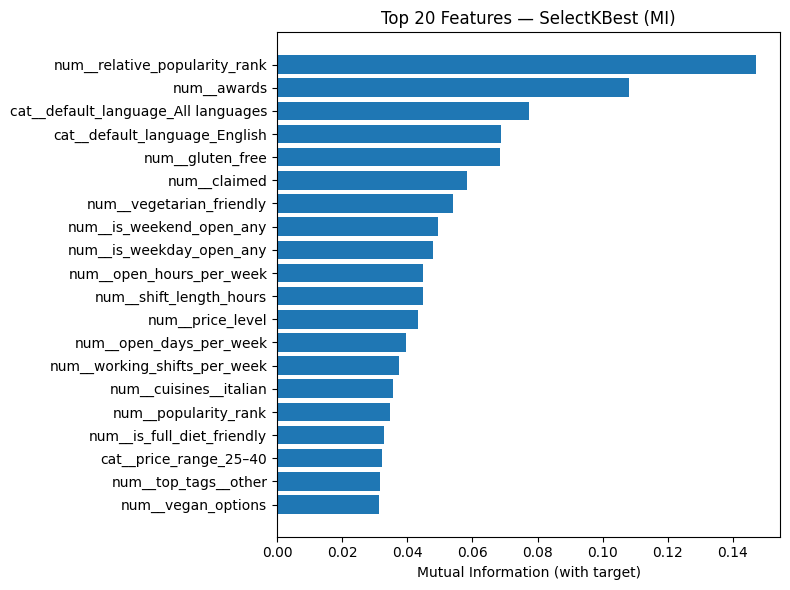

In [11]:
# After creating selected_df = pd.DataFrame({"Feature": ..., "MI_Score": ...})
topN = 20
top_mi = selected_df.sort_values("MI_Score", ascending=False).head(topN)
plt.figure(figsize=(8,6))
plt.barh(top_mi["Feature"][::-1], top_mi["MI_Score"][::-1])  # reverse for descending order on y-axis
plt.xlabel("Mutual Information (with target)")
plt.title(f"Top {topN} Features — SelectKBest (MI)")
plt.tight_layout()
plt.show()


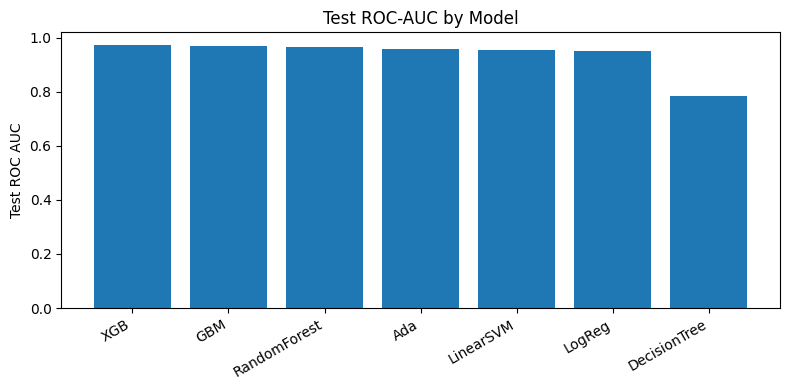

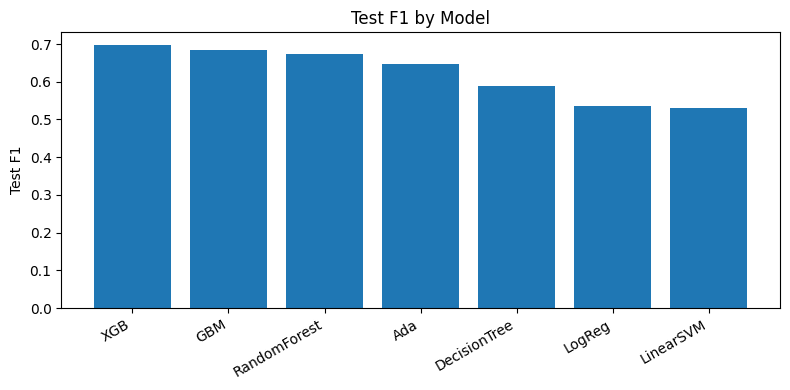

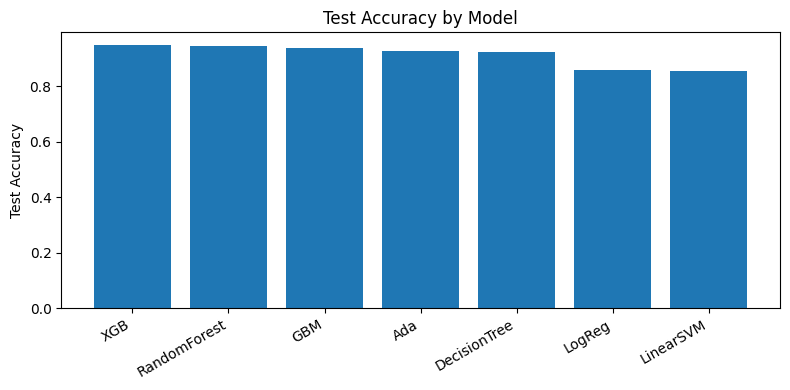

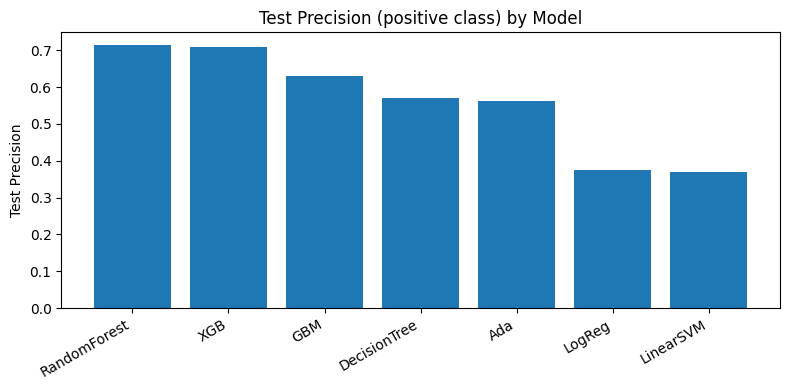

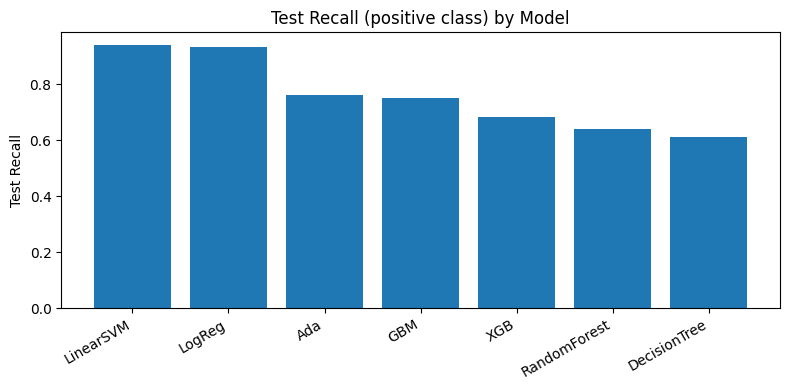

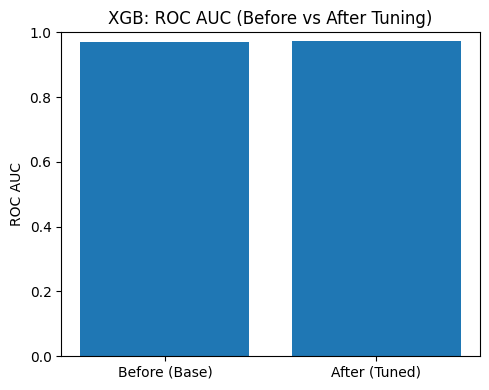

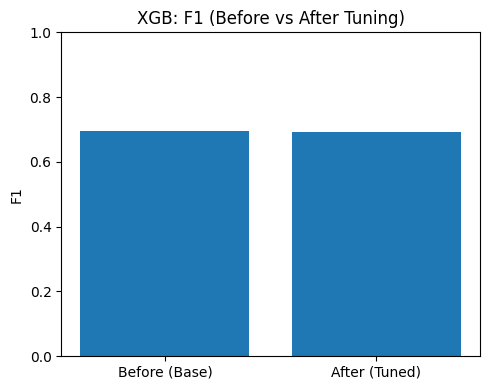

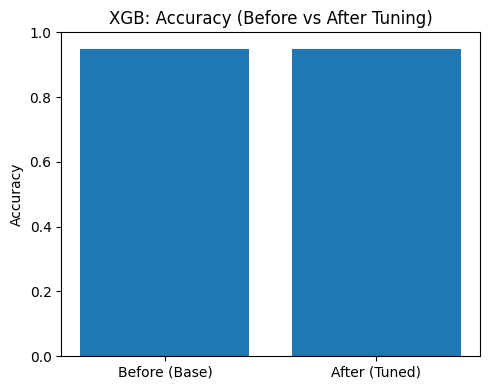

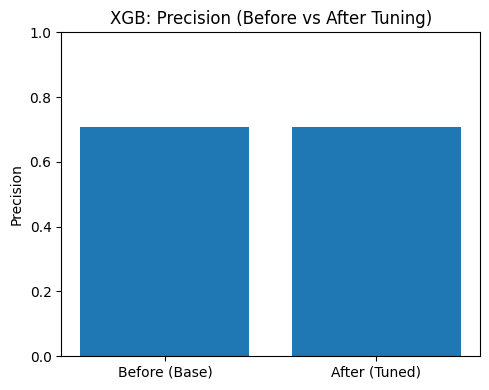

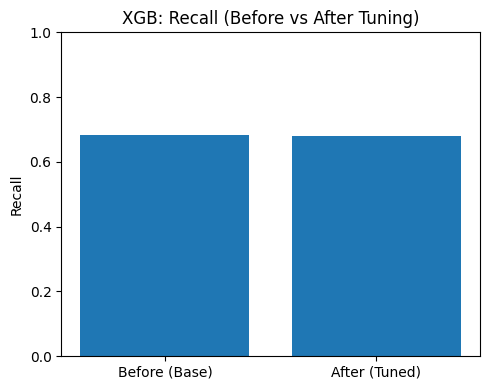

,Accuracy,Precision,Recall,F1,ROC AUC
Stage,,,,,
Before (Base),0.9482,0.7086,0.6845,0.6963,0.9716
After (Tuned),0.9478,0.7074,0.6786,0.6927,0.9721


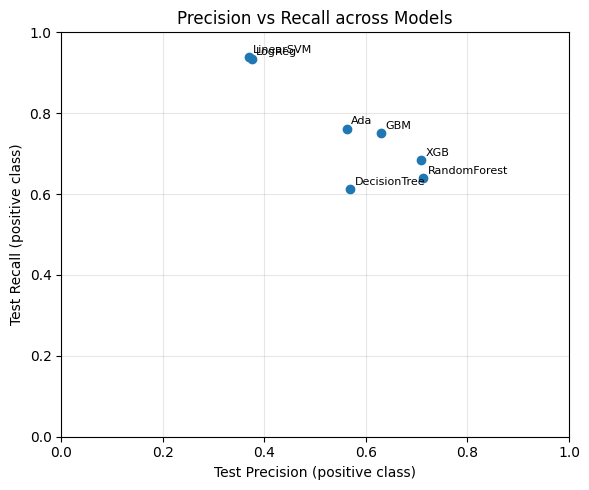

<Figure size 600x500 with 0 Axes>

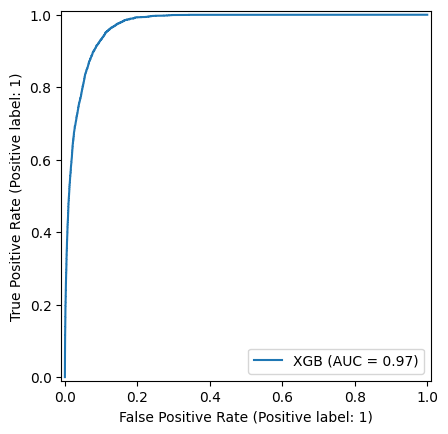

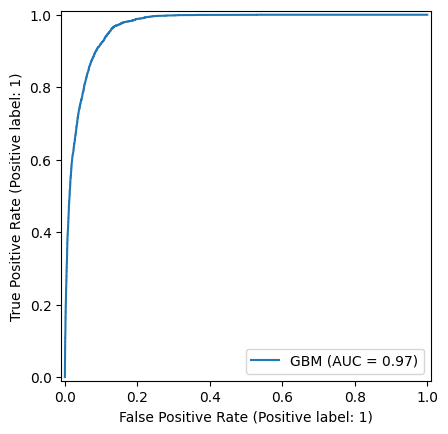

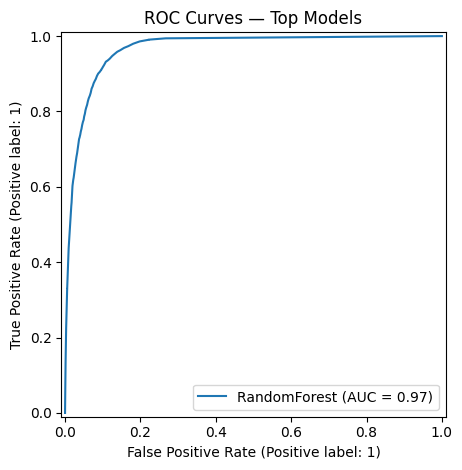

In [12]:
#Model comparison + pre/post tuning
phase1_results = joblib.load("phase1_results_df.joblib")  # results of each base model from Cell 2
X_train_raw, X_test_raw, y_train, y_test, *_ = joblib.load("data_split.joblib")

# A) Bar charts per metric across all models (Test set)

def plot_metric_bar(df, metric, title=None):
    df_ = df.copy()
    df_[metric] = pd.to_numeric(df_[metric], errors="coerce")
    df_ = df_[["Model", metric]].dropna().sort_values(metric, ascending=False)
    plt.figure(figsize=(8, 4))
    plt.bar(df_["Model"], df_[metric])
    plt.ylabel(metric.replace("_", " "))
    plt.xticks(rotation=30, ha="right")
    plt.title(title or f"Test {metric} by Model")
    plt.tight_layout()
    plt.show()

if phase1_results.empty:
    print("No models found in phase1_results_df.joblib. Run a few models in Cell 2 first.")
else:
    plot_metric_bar(phase1_results, "Test_ROC_AUC", "Test ROC-AUC by Model")
    plot_metric_bar(phase1_results, "Test_F1", "Test F1 by Model")
    plot_metric_bar(phase1_results, "Test_Accuracy", "Test Accuracy by Model")
    plot_metric_bar(phase1_results, "Test_Precision", "Test Precision (positive class) by Model")
    plot_metric_bar(phase1_results, "Test_Recall", "Test Recall (positive class) by Model")

# B) “Before vs After tuning” comparison for the winner

# Find the winner row from Phase 1 (highest ROC-AUC)
if not phase1_results.empty and phase1_results["Test_ROC_AUC"].notna().any():
    winner_row = phase1_results.sort_values("Test_ROC_AUC", ascending=False).iloc[0]
    winner_name = winner_row["Model"]

    # We saved tuned metrics in Cell 3 as selected_model_metrics.csv (if tuning ran)
    try:
        tuned_tbl = pd.read_csv("selected_model_metrics.csv")
        tuned_row = tuned_tbl.iloc[0]  # single row table

        # Build a tidy comparison frame
        before = {
            "Stage": "Before (Base)",
            "Accuracy": winner_row["Test_Accuracy"],
            "Precision": winner_row["Test_Precision"],
            "Recall": winner_row["Test_Recall"],
            "F1": winner_row["Test_F1"],
            "ROC AUC": winner_row["Test_ROC_AUC"],
        }
        after = {
            "Stage": "After (Tuned)",
            "Accuracy": tuned_row["Accuracy"],
            "Precision": tuned_row["Precision"],
            "Recall": tuned_row["Recall"],
            "F1": tuned_row["F1"],
            "ROC AUC": tuned_row["ROC AUC"],
        }
        cmp_df = pd.DataFrame([before, after])

        # Bar plot per metric (grouped by Stage)
        for metric in ["ROC AUC", "F1", "Accuracy", "Precision", "Recall"]:
            plt.figure(figsize=(5, 4))
            plt.bar(cmp_df["Stage"], cmp_df[metric])
            plt.ylim(0, 1)
            plt.title(f"{winner_name}: {metric} (Before vs After Tuning)")
            plt.ylabel(metric)
            plt.tight_layout()
            plt.show()

        # Small table printout for quick glance
        display(cmp_df.set_index("Stage").round(4))

    except FileNotFoundError:
        print("No tuned results file found (selected_model_metrics.csv). "
              "Run Cell 3 tuning to generate the after-tuning metrics.")

# --- C) Quick scatter: Precision–Recall tradeoff across models (Test set) ---

if not phase1_results.empty:
    df_scatter = phase1_results[["Model", "Test_Precision", "Test_Recall"]].dropna()
    if not df_scatter.empty:
        plt.figure(figsize=(6, 5))
        plt.scatter(df_scatter["Test_Precision"], df_scatter["Test_Recall"])
        for _, r in df_scatter.iterrows():
            plt.annotate(r["Model"], (r["Test_Precision"], r["Test_Recall"]), fontsize=8, xytext=(3,3), textcoords="offset points")
        plt.xlabel("Test Precision (positive class)")
        plt.ylabel("Test Recall (positive class)")
        plt.title("Precision vs Recall across Models")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Overlay ROC curves for the top-3 models
# This tries to load each saved pipeline and plot ROC on the test set if the model exposes
# predict_proba or decision_function. Skips gracefully otherwise.

from sklearn.metrics import RocCurveDisplay

def model_score_fn(pipeline, X):
    # Return a continuous score for ROC; prefer predict_proba, else decision_function
    clf = pipeline.named_steps.get("clf", None)
    if clf is None:
        return None
    if hasattr(clf, "predict_proba"):
        return pipeline.predict_proba(X)[:, 1]
    if hasattr(clf, "decision_function"):
        return pipeline.decision_function(X)
    return None

topN = min(3, len(phase1_results))
top_models = phase1_results.sort_values("Test_ROC_AUC", ascending=False).head(topN)

plt.figure(figsize=(6, 5))
curves_plotted = 0
for _, row in top_models.iterrows():
    try:
        pipe = joblib.load(row["Pipeline_Path"])
        y_score = model_score_fn(pipe, X_test_raw)
        if y_score is None:
            continue
        RocCurveDisplay.from_predictions(y_test, y_score, name=row["Model"])
        curves_plotted += 1
    except Exception as e:
        # Skip models that fail to load or score
        pass

if curves_plotted:
    plt.title("ROC Curves — Top Models")
    plt.tight_layout()
    plt.show()
else:
    print("Couldn’t plot multi-model ROC (no suitable scores).")
